## Importing Required Libraries

In [56]:
import keras
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.applications.vgg19 import VGG19

In [57]:
# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from keras import backend as K
import cv2
import numpy as np
from tqdm import tqdm
import os
import matplotlib
from pathlib import Path
import random
from PIL import Image

In [3]:
model_path = r"C:\Users\AVLguest\work\Random_experiments\Synthetic_texture\new_data\new_plots\tex_2_and_4_nodropout_gray\VGG19/VGG_texture_Fiber_2_and_4_gray_no_dropout.hdf5"


# Loading Data

In [25]:
train_dir = [r"C:\Users\AVLguest\work\Random_experiments\Synthetic_texture\new_data\wood_2_images/", r"C:\Users\AVLguest\work\Random_experiments\Synthetic_texture\new_data\wood_4_images/"]

In [26]:
def image_process(dataset_path, im_size, images_names):
    count = 0
    images = []
    for f in tqdm(images_names):    
        path =  os.path.join(dataset_path , f )
#         print(path)
        img = cv2.imread(path)
        img = gray_image(img)
#         print(img.shape)
        img = cv2.resize(img, (im_size, im_size)) #read through the function.
        
        x = np.expand_dims(img, axis=0)
               # x = preprocess_input(x)
        images.append(x)

    images = np.array(images).reshape(len(images), im_size, im_size,3)
    return images

In [27]:
image_names_0 = os.listdir(train_dir[0])
image_names_1 = os.listdir(train_dir[1])

In [28]:
image_names = image_names_0 + image_names_1

In [30]:
min_length = 9000
image_names_0 = image_names_0[:min_length]
image_names_1 = image_names_1[:min_length]

In [31]:
X_train_0_all = image_process(train_dir[0], 240, image_names_0)
X_train_1_all = image_process(train_dir[1], 240, image_names_1)
y_train_all = [0]*(len(image_names_0)) + [1]*(len(image_names_1))

100%|██████████| 7018/7018 [00:23<00:00, 298.61it/s]


In [32]:
X_train_all = np.concatenate((X_train_0_all, X_train_1_all))

In [33]:
len(X_train_all), len(y_train_all)

(14099, 14099)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_train_all,y_train_all, test_size=0.3, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=10)

In [36]:
np.array(X_train).shape,np.array(X_val).shape , np.array(X_test).shape

((7895, 240, 240, 3), (1974, 240, 240, 3), (4230, 240, 240, 3))

In [37]:
y_val.count(1), y_val.count(0)

(995, 979)

# Viewing Sample images 

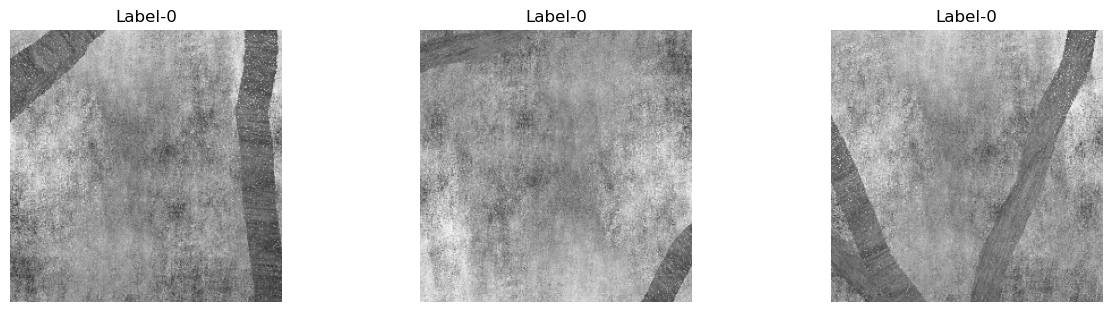

In [44]:
import os
import random
import matplotlib.image as mpimg
plt.figure(figsize = (15,12))

for i in range(3):
    ax = plt.subplot(3,3,i+1)
    ind = random.randint(1,4000)
#     filepath = train_dir[0] + "/" + image_name.
    img = X_train_0_all[ind]
    plt.imshow(img)
    plt.title("Label-" + str(y_train_all[ind]))
    plt.axis(False)


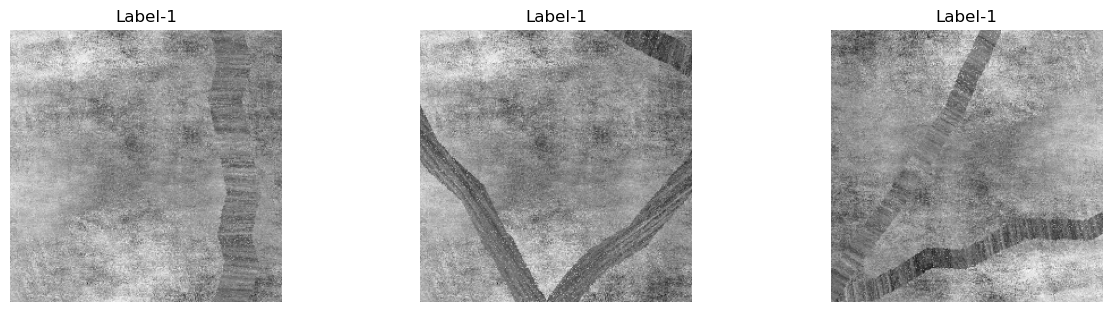

In [45]:
import os
import random
import matplotlib.image as mpimg
plt.figure(figsize = (15,12))

for i in range(3):
    ax = plt.subplot(3,3,i+1)
    ind = random.randint(1,4000)
#     filepath = train_dir[0] + "/" + image_name.
    img = X_train_1_all[ind]
    plt.imshow(img)
    plt.title("Label-" + str(1))
    plt.axis(False)


# Training the EfficientNet Pretrained Model

In [58]:
def create_model(base_model):
    
    # Deactivate dropout layers
    for layer in base_model.layers:
        if isinstance(layer, tf.keras.layers.Dropout):
            layer.rate = 0.0

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add a GlobalAveragePooling2D layer and a Dense layer on top of the base model
    x = tf.keras.layers.GlobalAveragePooling2D(name = "global_avg_pool")(base_model.output)
#     x = layers.Dropout(0.25)(x) 
    outputs = layers.Dense(2, activation = "softmax", name = "output_layer")(x)
#     x = layers.Dropout(0.5)(x) 
    model = tf.keras.Model(inputs=base_model.input, outputs = outputs)

    model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy() ,  #"categorical_crossentropy",
             optimizer = tf.keras.optimizers.Adam(),
             metrics = ['accuracy'])

    return model

In [59]:
base_model = VGG19(include_top=False, weights='imagenet')
model = create_model(base_model)

In [61]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [63]:
model_path = r'C:\Users\AVLguest\work\Random_experiments\Synthetic_texture\VGG19\VGG_wood_2_wood_4.hdf5'
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
filepath = model_path
checkpoint = ModelCheckpoint(filepath, monitor = "val_accuracy", verbose = 1, save_best_only= True, mode = "max")
callbacks_list = [checkpoint]

In [64]:
history1 = model.fit(np.array(X_train),
                     np.array(y_train),
                     epochs = 50,
                     batch_size = 16,
                     validation_data = (np.array(X_val), np.array(y_val)),
#                      validation_steps = len(testDataALL),
                     callbacks = callbacks_list 
                    )

Epoch 1/50
494/494 [==============================] - ETA: 0s - loss: 0.4299 - accuracy: 0.8114
Epoch 1: val_accuracy improved from -inf to 0.88298, saving model to C:\Users\AVLguest\work\Random_experiments\Synthetic_texture\VGG19\VGG_wood_2_wood_4.hdf5
494/494 [==============================] - 32s 56ms/step - loss: 0.4299 - accuracy: 0.8114 - val_loss: 0.2720 - val_accuracy: 0.8830
Epoch 2/50
494/494 [==============================] - ETA: 0s - loss: 0.2412 - accuracy: 0.8988
Epoch 2: val_accuracy improved from 0.88298 to 0.91692, saving model to C:\Users\AVLguest\work\Random_experiments\Synthetic_texture\VGG19\VGG_wood_2_wood_4.hdf5
494/494 [==============================] - 27s 54ms/step - loss: 0.2412 - accuracy: 0.8988 - val_loss: 0.2061 - val_accuracy: 0.9169
Epoch 3/50
494/494 [==============================] - ETA: 0s - loss: 0.2065 - accuracy: 0.9137
Epoch 3: val_accuracy improved from 0.91692 to 0.92300, saving model to C:\Users\AVLguest\work\Random_experiments\Synthetic_tex

Epoch 28/50
494/494 [==============================] - ETA: 0s - loss: 0.1341 - accuracy: 0.9452
Epoch 28: val_accuracy did not improve from 0.93769
494/494 [==============================] - 27s 54ms/step - loss: 0.1341 - accuracy: 0.9452 - val_loss: 0.1725 - val_accuracy: 0.9352
Epoch 29/50
493/494 [============================>.] - ETA: 0s - loss: 0.1334 - accuracy: 0.9452
Epoch 29: val_accuracy did not improve from 0.93769
494/494 [==============================] - 27s 54ms/step - loss: 0.1333 - accuracy: 0.9453 - val_loss: 0.1744 - val_accuracy: 0.9331
Epoch 30/50
494/494 [==============================] - ETA: 0s - loss: 0.1387 - accuracy: 0.9429
Epoch 30: val_accuracy did not improve from 0.93769
494/494 [==============================] - 27s 54ms/step - loss: 0.1387 - accuracy: 0.9429 - val_loss: 0.1784 - val_accuracy: 0.9331
Epoch 31/50
494/494 [==============================] - ETA: 0s - loss: 0.1376 - accuracy: 0.9455
Epoch 31: val_accuracy did not improve from 0.93769
494/4

## Training Plots

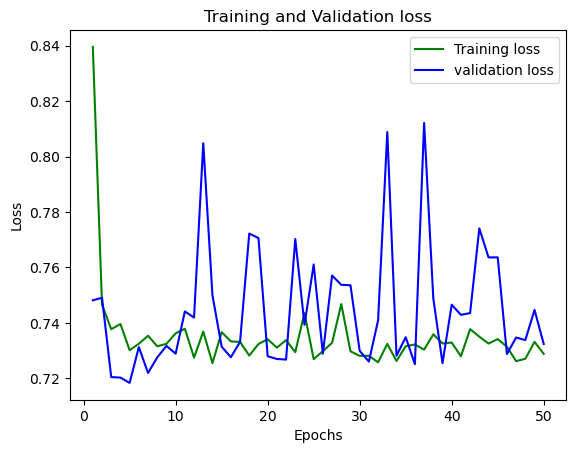

In [316]:
    loss_train = history1.history['loss']
    loss_val = history1.history['val_loss']
    epochs = range(1,51)
    plt.plot(epochs, loss_train, 'g', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
#     plt.savefig(r"C:\Users\AVLguest\work\Random_experiments\Synthetic_texture\new_data" + '/Training and Validation Loss-VGG19-2_and_4-gray.png')
    plt.show()

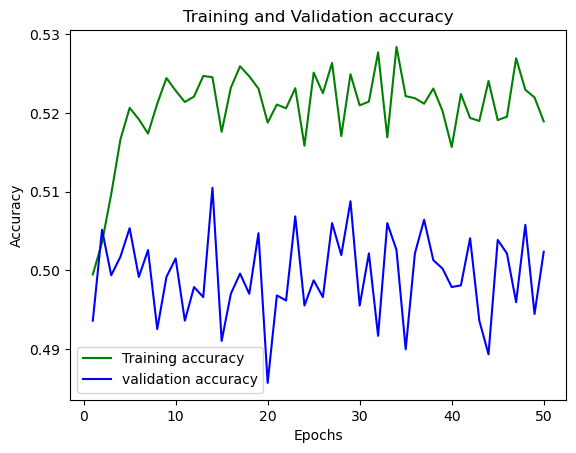

In [317]:
    loss_train = history1.history['accuracy']
    loss_val = history1.history['val_accuracy']
    epochs = range(1,51)
    plt.plot(epochs, loss_train, 'g', label='Training accuracy')
    plt.plot(epochs, loss_val, 'b', label='validation accuracy')
    plt.title('Training and Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
#     plt.savefig(r"C:\Users\AVLguest\work\Random_experiments\Synthetic_texture\new_data/" + 'Training and Validation Accuracy-VGG19-2_and_4-gray.png')
    plt.show()

## Evaluating the test data

In [318]:
# loading the save model
from keras.models import load_model
# load_model = load_model(r"C:\Users\AVLguest\Downloads/model_dogs_and_cats.hdf5")
load_model = load_model(model_path)

In [319]:
load_model.summary()

Model: "model_20739"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   

In [31]:
from tensorflow.keras.models import load_model
model_path = r"C:\Users\AVLguest\work\Random_experiments\Synthetic_texture\new_data\new_plots\tex_2_and_4_nodropout_gray\VGG19/VGG19_Texture_Fiber_2_and_4_gray_no_dropout.hdf5"
load_model = load_model(model_path)
pred_list = []
model = load_model
y_preds = model.predict(np.array(X_train))
for i in y_preds:
    if i[0] > i[1]:
        pred_list.append(0)
    else:
        pred_list.append(1)
print("Accuracy is: ", accuracy_score(y_train, pred_list))

585/585 [==============================] - 48s 77ms/step
Accuracy is:  0.977598374679213


## Confusion matrix for texture test data

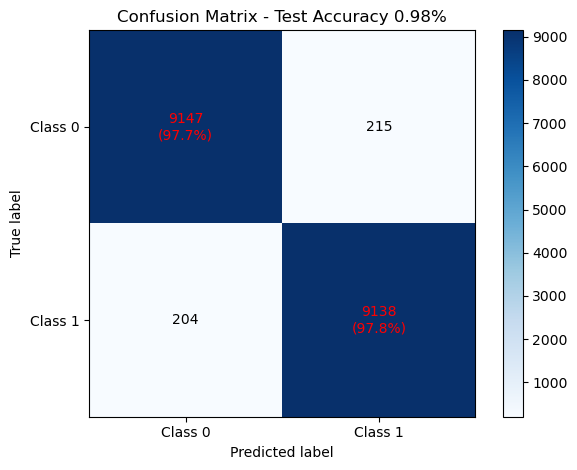

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate sample data
y_true = y_train
y_pred = pred_list

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate class accuracies
class_accuracies = cm.diagonal() / cm.sum(axis=1)

# Calculate total accuracy
total_accuracy = np.sum(np.diagonal(cm)) / np.sum(cm)

# Plot confusion matrix with class accuracies
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Test Accuracy ' + str(round(class_accuracies[0] + class_accuracies[1], 2) / 2) + "%")
plt.colorbar()
tick_marks = np.arange(len(cm))
plt.xticks(tick_marks, ['Class 0', 'Class 1'])
plt.yticks(tick_marks, ['Class 0', 'Class 1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')

# Add labels to each cell in the confusion matrix
thresh = cm.max() / 2
for i, j in np.ndindex(cm.shape):
    if i == j:
        plt.text(j, i, f'{cm[i, j]}\n({class_accuracies[i] * 100:.1f}%)', ha='center', va='center',
             color='red' if cm[i, j] > thresh else 'black')
    else:
        plt.text(j, i, f'{cm[i, j]}', ha='center', va='center',
             color='red' if cm[i, j] > thresh else 'black')
        

plt.tight_layout()
plt.show()


## Displaying the predictions on test images

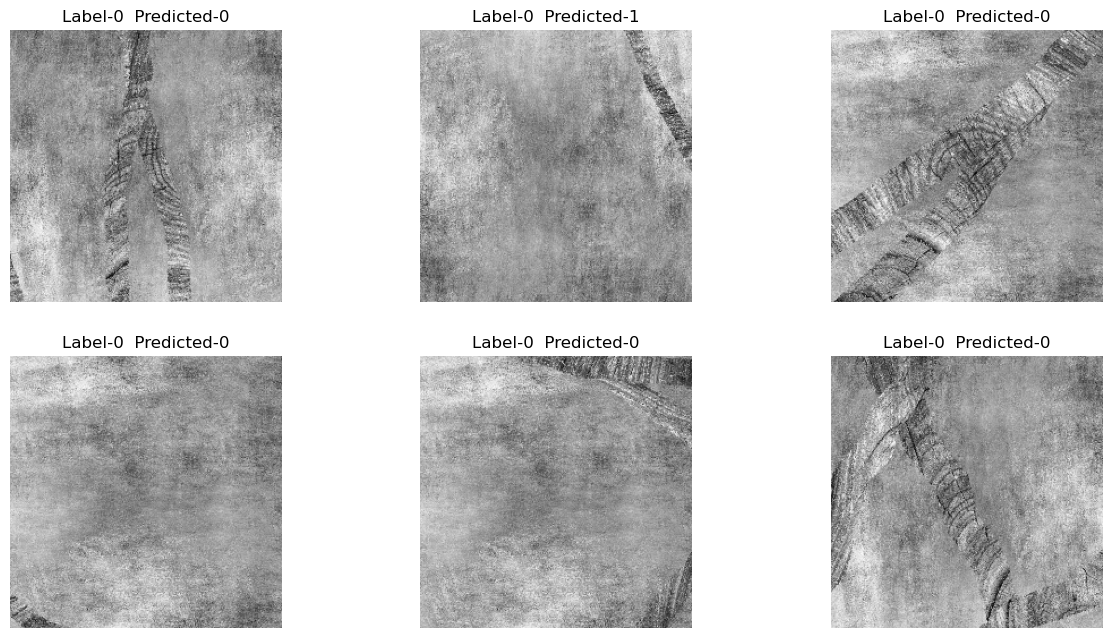

In [68]:
import os
import random
import matplotlib.image as mpimg

plt.figure(figsize = (15,12))
for i in range(6):
    ax = plt.subplot(3,3,i+1)
    ind = random.randint(1, len(X_test))
    plt.imshow(X_test[ind])
    plt.title("Label-" + str(y_test[ind]) + "  Predicted-" + str(pred_list[ind]))
    plt.axis(False)

In [68]:
def display_gradcam(img_path, heatmap, alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)
    img = gray_image(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = matplotlib.colormaps.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    print(jet_heatmap.shape)
    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    # superimposed_img.save(cam_path)

#     Display Grad CAM
    plt.imshow(superimposed_img)
    plt.show()


In [69]:
def save_and_display_gradcam(img_path, heatmap, cam_path, alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)
    img = gray_image(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = matplotlib.colormaps.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))


In [70]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    # # We multiply each channel in the feature map array
    # # by "how important this channel is" with regard to the top predicted class
    # # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Visualizing grad cam for predicted class and unpredicted class

In [326]:
img_path = r"C:\Users\AVLguest\work\Random_experiments\Synthetic_texture\new_data\texture_2_images/image_42.jpg"
image = cv2.imread(img_path)
img = gray_image(image)
im_size = 240
img = cv2.resize(img, (im_size, im_size))
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
x = np.expand_dims(img, axis = 0)


## Grad-cam for predicted class

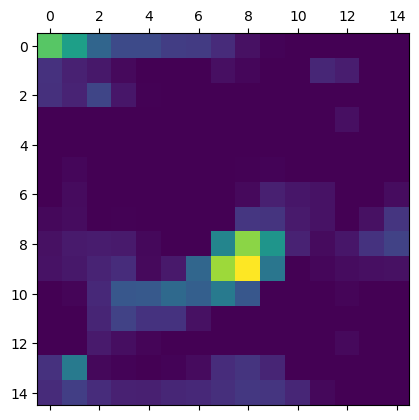

(15, 15, 3)


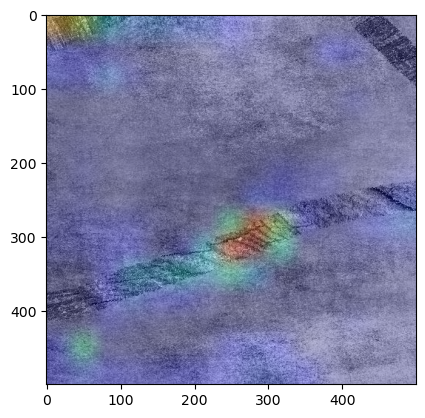

In [328]:
from keras.models import load_model
load_model = load_model(model_path)
model = load_model

# model.layers[-1].activation = None

last_conv_layer_name = 'block5_conv4' #top_conv

heatmap = make_gradcam_heatmap(x, model, last_conv_layer_name)
plt.matshow(heatmap)
plt.show()
display_gradcam(img_path, heatmap, alpha=0.4)

## Grad-cam for Other Class

In [71]:
def make_gradcam_heatmap1(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        print( preds.shape, preds)
        if pred_index is None:
            pred_index = tf.argmin(preds[0])
            print(tf.argmin(preds[0]), "tf.argmin(preds[0])")
        class_channel = preds[:, pred_index]
        print(class_channel, "class_channel")

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)
    # # This is a vector where each entry is the mean intensity of the gradient
    # # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    # # We multiply each channel in the feature map array
    # # by "how important this channel is" with regard to the top predicted class
    # # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

(1, 2) tf.Tensor([[9.9999988e-01 6.6401384e-08]], shape=(1, 2), dtype=float32)
tf.Tensor(1, shape=(), dtype=int64) tf.argmin(preds[0])
tf.Tensor([6.6401384e-08], shape=(1,), dtype=float32) class_channel


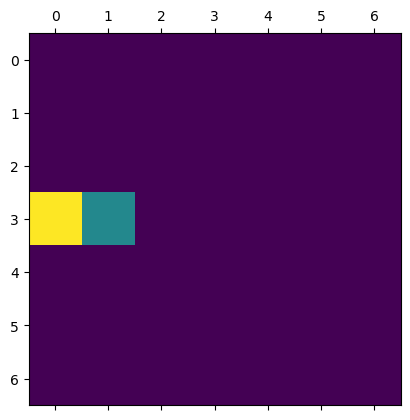

(7, 7, 3)


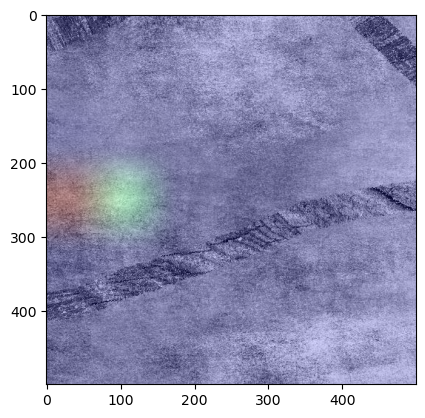

In [162]:
heatmap2 = make_gradcam_heatmap1(x, model, last_conv_layer_name)
plt.matshow(heatmap2)
plt.show()
display_gradcam(img_path, heatmap2, alpha=0.4)

## Combining heatmaps for both classes and visualizing the gradcam

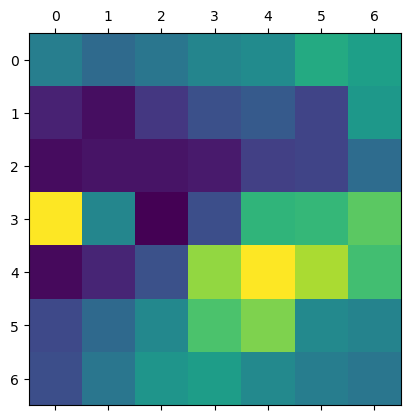

In [163]:
plt.matshow(heatmap+heatmap2)

(7, 7, 3)


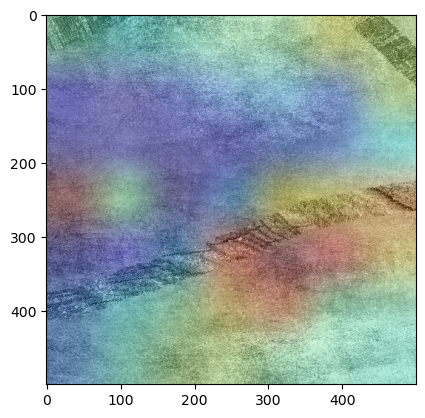

In [164]:
display_gradcam(img_path, heatmap+heatmap2, alpha=0.4)

In [165]:
def guided_model(load_model, last_conv_layer_name):
    model = load_model

    model.get_layer(last_conv_layer_name)

    gb_model = tf.keras.models.Model(
        inputs = [model.inputs],    
        outputs = [model.get_layer(last_conv_layer_name).output]
    )
    layer_dict = [layer for layer in gb_model.layers[1:] if hasattr(layer,'activation')]
    
    @tf.custom_gradient
    def guidedRelu(a):
        def grad(dy):
            return tf.cast(dy>0,"float32") * tf.cast(a>0, "float32") * dy
        return tf.nn.relu(a), grad
    for l in layer_dict:
        if l.activation == tf.keras.activations.relu:
            l.activation = guidedRelu
    return gb_model

In [166]:
def guided_back(preprocessed_input, gb_model):
    with tf.GradientTape() as tp:
        inputs = tf.cast(preprocessed_input, tf.float32)
        tp.watch(inputs)
        outputs = gb_model(inputs)[0][0][0]
        grads = tp.gradient(outputs,inputs)[0]
    gb_prop = grads
    guided_back_viz = np.dstack((
                gb_prop[:, :, 0],
                gb_prop[:, :, 1],
                gb_prop[:, :, 2],
            ))  

    guided_back_viz -= np.min(guided_back_viz)
    guided_back_viz /= guided_back_viz.max()
    return guided_back_viz

In [167]:
def guided_model_swish(load_model, last_conv_layer_name):
    model = load_model

    model.get_layer(last_conv_layer_name)

    gb_model = tf.keras.models.Model(
        inputs = [model.inputs],    
        outputs = [model.get_layer(last_conv_layer_name).output]
    )
    layer_dict = [layer for layer in gb_model.layers[1:] if hasattr(layer,'activation')]
    # print(layer_dict)
    @tf.custom_gradient
    def guidedSwish(a):
        def grad(dy):
            sigmoid = tf.math.sigmoid(a)
            positive_mask_1 = tf.cast(a>0,"float32") 
            positive_mask_2 = tf.cast(dy>0,"float32") 
            return dy * (sigmoid * (1 + a * (1 - sigmoid))) * positive_mask_1 * positive_mask_2
        return swish(a), grad

    for l in layer_dict:
        if l.activation == tf.keras.activations.swish:
            l.activation = guidedSwish
#             print(l.activation.__name__, l)

    return gb_model

## Visualizing Guided BackPropogation

In [168]:
img_path = r"C:\Users\AVLguest\work\Random_experiments\Synthetic_texture\new_data\texture_2_images/image_42.jpg"
image = cv2.imread(img_path)
img = gray_image(img)
im_size = 240
img = cv2.resize(image, (im_size, im_size)) 
x = np.expand_dims(img, axis = 0)
x = np.array(x[:,:,:,0:3]).reshape(1,240,240,3)

In [173]:
from tensorflow.keras.activations import swish
from keras.models import load_model
last_conv_layer_name = 'top_conv'   #block5_conv4
# model = load_model
model = load_model(model_path)
gb_model = guided_model_swish(model, last_conv_layer_name)
output1 = guided_back(x, gb_model)

In [174]:
def deprocess_image(x):
    """Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    """
    x = x.copy()
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    #if K.image_dim_ordering() == 'th':
    if K.image_data_format() == 'th':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

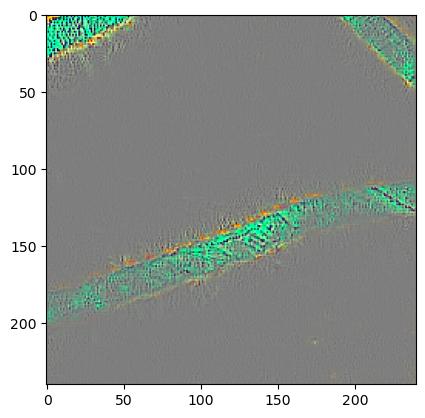

In [175]:
plt.imshow(deprocess_image(output1))
plt.show()

# Saving Grad Cam results

In [88]:
from keras.models import load_model
model_path = r"C:\Users\AVLguest\work\Random_experiments\Synthetic_texture\new_data\new_plots\tex_2_and_4_nodropout_gray-shuffle\EfficientNet-B1/model_Texture_Fiber_2_and_4_gray_no_dropout-shuffle.hdf5"
model = load_model(model_path)
pred_list = []
last_conv_layer_name = 'top_conv'

## Train gradcams

In [90]:
count = 0
for i, filename in enumerate(os.listdir(r"C:\Users\AVLguest\work\Random_experiments\Synthetic_texture\new_data\texture_2_images_new/")):
    
    img_path = os.path.join(r"C:\Users\AVLguest\work\Random_experiments\Synthetic_texture\new_data\texture_2_images_new/",filename)
#     print(img_path)
    image = cv2.imread(img_path)
    im_size = 240
    img = gray_image(image)
    img = cv2.resize(img, (im_size, im_size)) #read through the function.
#     img = cv2.cvtColor(img, cv2.COLOR_BGRRGB)
    x = np.expand_dims(img, axis = 0)
#     x = np.array(x[:,:,:,0:3]).reshape(1,240, 240, 3)
    y_pred = model.predict(x).flatten()
#     print(y_pred)
#     ind = image_names_0.index(filename)
#     label = y_train_0_all[ind]
    label = 0
    if y_pred[0] > y_pred[1]:
            pred = "Label 0"
            prob = int(y_pred[0]*100)
            count+=1
    else:
            pred = "Label 1"
            prob =  int(y_pred[1]*100)
            
#     print(y_pred, pred)
    
    prob = str(prob)
#     if count == 1:
#         break
    heatmap = make_gradcam_heatmap(x, model, last_conv_layer_name)
    output_path = os.path.join(r"C:\Users\AVLguest\work\Random_experiments\Synthetic_texture\new_data\new_plots\tex_2_and_4_nodropout_gray-shuffle\EfficientNet-B1\gradcams/", "Actual_" + str(label) + " - " +  "Predicted_" + pred + " - "+ "Prob_" + prob +" - "+ filename )
    save_and_display_gradcam(img_path, heatmap, output_path, alpha=0.4)

1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 28ms/step


In [ ]:
for i, filename in enumerate(os.listdir(r"C:\Users\AVLguest\work\Random_experiments\Synthetic_texture\Data\Texture\rectangle/")):
    
    img_path = os.path.join(r"C:\Users\AVLguest\work\Random_experiments\Synthetic_texture\Data\Texture\rectangle/",filename)
#     print(img_path)
    image = cv2.imread(img_path)
    im_size = 240
    img = cv2.resize(image, (im_size, im_size)) #read through the function.
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x = np.expand_dims(img, axis = 0)
#     x = np.array(x[:,:,:,0:3]).reshape(1,240, 240, 3)
    y_pred = model.predict(x).flatten()
#     print(y_pred)
    if y_pred[0] > y_pred[1]:
            pred = "Circle"
            prob = int(y_pred[0]*100)
    else:
            pred = "Rect"
            prob =  int(y_pred[1]*100)
    prob = str(prob)
    heatmap = make_gradcam_heatmap(x, model, last_conv_layer_name)

    output_path = os.path.join(r"C:\Users\AVLguest\work\Random_experiments\Synthetic_texture\efficientnet\texture_gradcam\train", "Actual_Rect - " +  "Predicted_" + pred + " - "+ "Prob_" + prob +" - "+ filename )
    save_and_display_gradcam(img_path, heatmap, output_path, alpha=0.4)

## Test Gradcams

In [51]:
for i, filename in enumerate(os.listdir(r"C:\Users\AVLguest\work\Random_experiments\Synthetic_texture\Data\Texture-Test\circle")):
    
    img_path = os.path.join(r"C:\Users\AVLguest\work\Random_experiments\Synthetic_texture\Data\Texture-Test\circle",filename)
    print(filename)
    image = cv2.imread(img_path)
    im_size = 240
    img = cv2.resize(image, (im_size, im_size)) #read through the function.
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x = np.expand_dims(img, axis = 0)
#     x = np.array(x[:,:,:,0:3]).reshape(1,240, 240, 3)
    y_pred = model.predict(x).flatten()
    print(y_pred)
    if y_pred[0] > y_pred[1]:
            pred = "Circle"
            prob = int(y_pred[0]*100)
    else:
            pred = "Rect"
            prob =  int(y_pred[1]*100)
    prob = str(prob)
    heatmap = make_gradcam_heatmap(x, model, last_conv_layer_name)

    output_path = os.path.join(r"C:\Users\AVLguest\work\Random_experiments\Synthetic_texture\efficientnet\texture_gradcam\test", "Actual_Circle - " +  "Predicted_" + pred + " - "+ "Prob_" + prob +" - "+ filename )
    save_and_display_gradcam(img_path, heatmap, output_path, alpha=0.4)

synthetic_image_0.jpg
1/1 [==============================] - 0s 29ms/step
[0.28329515 0.71670485]
synthetic_image_1.jpg
1/1 [==============================] - 0s 25ms/step
[0.85120845 0.14879152]
synthetic_image_10.jpg
1/1 [==============================] - 0s 24ms/step
[0.46425998 0.53574   ]
synthetic_image_11.jpg
1/1 [==============================] - 0s 18ms/step
[0.3539593  0.64604074]
synthetic_image_12.jpg
1/1 [==============================] - 0s 22ms/step
[0.23738319 0.7626168 ]
synthetic_image_13.jpg
1/1 [==============================] - 0s 27ms/step
[0.39425817 0.60574186]
synthetic_image_14.jpg
1/1 [==============================] - 0s 19ms/step
[0.45846537 0.5415346 ]
synthetic_image_15.jpg
1/1 [==============================] - 0s 29ms/step
[0.57880545 0.42119455]
synthetic_image_16.jpg
1/1 [==============================] - 0s 31ms/step
[0.78997403 0.210026  ]
synthetic_image_17.jpg
1/1 [==============================] - 0s 14ms/step
[0.8529183  0.14708166]
synthetic_im

In [52]:
for i, filename in enumerate(os.listdir(r"C:\Users\AVLguest\work\Random_experiments\Synthetic_texture\Data\Texture-Test\rectangle")):
    
    img_path = os.path.join(r"C:\Users\AVLguest\work\Random_experiments\Synthetic_texture\Data\Texture-Test\rectangle",filename)
    print(filename)
    image = cv2.imread(img_path)
    im_size = 240
    img = cv2.resize(image, (im_size, im_size)) #read through the function.
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x = np.expand_dims(img, axis = 0)
#     x = np.array(x[:,:,:,0:3]).reshape(1,240, 240, 3)
    y_pred = model.predict(x).flatten()
    print(y_pred)
    if y_pred[0] > y_pred[1]:
            pred = "Circle"
            prob = int(y_pred[0]*100)
    else:
            pred = "Rect"
            prob =  int(y_pred[1]*100)
    prob = str(prob)
    heatmap = make_gradcam_heatmap(x, model, last_conv_layer_name)

    output_path = os.path.join(r"C:\Users\AVLguest\work\Random_experiments\Synthetic_texture\efficientnet\texture_gradcam\test", "Actual_Rect - " +  "Predicted_" + pred + " - "+ "Prob_" + prob +" - "+ filename )
    save_and_display_gradcam(img_path, heatmap, output_path, alpha=0.4)

synthetic_image_0.jpg
1/1 [==============================] - 0s 32ms/step
[0.318521   0.68147904]
synthetic_image_1.jpg
1/1 [==============================] - 0s 26ms/step
[0.28183317 0.7181668 ]
synthetic_image_10.jpg
1/1 [==============================] - 0s 22ms/step
[0.1461831 0.8538169]
synthetic_image_11.jpg
1/1 [==============================] - 0s 31ms/step
[0.70806766 0.29193234]
synthetic_image_12.jpg
1/1 [==============================] - 0s 21ms/step
[0.912156   0.08784405]
synthetic_image_13.jpg
1/1 [==============================] - 0s 16ms/step
[0.1055275 0.8944725]
synthetic_image_14.jpg
1/1 [==============================] - 0s 16ms/step
[0.70042074 0.29957926]
synthetic_image_15.jpg
1/1 [==============================] - 0s 35ms/step
[0.22776271 0.77223724]
synthetic_image_16.jpg
1/1 [==============================] - 0s 30ms/step
[0.26435715 0.7356429 ]
synthetic_image_17.jpg
1/1 [==============================] - 0s 30ms/step
[0.44254285 0.5574571 ]
synthetic_image_

# Saving Guided Backprop results

## Train GuidedBackProp

In [79]:
gb_model = guided_model_swish(model, last_conv_layer_name)
for i, filename in enumerate(os.listdir(r"C:\Users\AVLguest\Downloads\Texture\rectangle/")):
    
    img_path = os.path.join(r"C:\Users\AVLguest\Downloads\Texture\rectangle/",filename)
#     print(img_path)
    image = cv2.imread(img_path)
    im_size = 240
    img = cv2.resize(image, (im_size, im_size)) #read through the function.
    x = np.expand_dims(img, axis = 0)
    x = np.array(x[:,:,:,0:3]).reshape(1,240, 240, 3)
    y_pred = model.predict(x).flatten()
#     print(y_pred)
    if y_pred[0] > y_pred[1]:
            pred = "Circle"
            prob =  int(y_pred[0]*100)
    else:
            pred = "Rect"
            prob =  int(y_pred[1]*100)
    prob = str(prob)
    output1 = deprocess_image(guided_back(x, gb_model))
    output_path = os.path.join(r"C:\Users\AVLguest\Downloads\texture_guidedbackprop/train", "Actual_Rect - " +  "Predicted_" + pred + " - "+ "Prob_" + prob +" - "+ filename )
    prop_img = keras.utils.img_to_array(output1)
    prop_img = cv2.resize(prop_img, (512, 384))
    prop_img = keras.utils.array_to_img(prop_img)

    # Save the superimposed image
    prop_img.save(output_path)


1/1 [==============================] - 0s 30ms/step


error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


In [81]:
gb_model = guided_model_swish(model, last_conv_layer_name)
for i, filename in enumerate(os.listdir(r"C:\Users\AVLguest\Downloads\Texture\circle/")):
    
    img_path = os.path.join(r"C:\Users\AVLguest\Downloads\Texture\circle/",filename)
#     print(img_path)
    image = cv2.imread(img_path)
    im_size = 240
    img = cv2.resize(image, (im_size, im_size)) #read through the function.
    x = np.expand_dims(img, axis = 0)
    x = np.array(x[:,:,:,0:3]).reshape(1,240, 240, 3)
    y_pred = model.predict(x).flatten()
#     print(y_pred)
    if y_pred[0] > y_pred[1]:
            pred = "Circle"
            prob =  int(y_pred[0]*100)
    else:
            pred = "Rect"
            prob =  int(y_pred[1]*100)
    prob = str(prob)
    output1 = deprocess_image(guided_back(x, gb_model))
    output_path = os.path.join(r"C:\Users\AVLguest\Downloads\texture_guidedbackprop/train", "Actual_Circle - " +  "Predicted_" + pred + " - "+ "Prob_" + prob +" - "+ filename )
    prop_img = keras.utils.img_to_array(output1)
    prop_img = cv2.resize(prop_img, (512, 384))
    prop_img = keras.utils.array_to_img(prop_img)

    # Save the superimposed image
    prop_img.save(output_path)


1/1 [==============================] - 0s 31ms/step


## Test Guided Backprop

In [82]:
gb_model = guided_model_swish(model, last_conv_layer_name)
for i, filename in enumerate(os.listdir(r"C:\Users\AVLguest\Downloads\Texture-Test\circle/")):
    
    img_path = os.path.join(r"C:\Users\AVLguest\Downloads\Texture-Test\circle/",filename)
#     print(img_path)
    image = cv2.imread(img_path)
    im_size = 240
    img = cv2.resize(image, (im_size, im_size)) #read through the function.
    x = np.expand_dims(img, axis = 0)
    x = np.array(x[:,:,:,0:3]).reshape(1,240, 240, 3)
    y_pred = model.predict(x).flatten()
#     print(y_pred)
    if y_pred[0] > y_pred[1]:
            pred = "Circle"
            prob =  int(y_pred[0]*100)
    else:
            pred = "Rect"
            prob =  int(y_pred[1]*100)
    prob = str(prob)
    output1 = deprocess_image(guided_back(x, gb_model))
    output_path = os.path.join(r"C:\Users\AVLguest\Downloads\texture_guidedbackprop/test", "Actual_Circle - " +  "Predicted_" + pred + " - "+ "Prob_" + prob +" - "+ filename )
    prop_img = keras.utils.img_to_array(output1)
    prop_img = cv2.resize(prop_img, (512, 384))
    prop_img = keras.utils.array_to_img(prop_img)

    # Save the superimposed image
    prop_img.save(output_path)


1/1 [==============================] - 0s 32ms/step


In [83]:
gb_model = guided_model_swish(model, last_conv_layer_name)
for i, filename in enumerate(os.listdir(r"C:\Users\AVLguest\Downloads\Texture-Test\rectangle/")):
    
    img_path = os.path.join(r"C:\Users\AVLguest\Downloads\Texture-Test\rectangle/",filename)
#     print(img_path)
    image = cv2.imread(img_path)
    im_size = 240
    img = cv2.resize(image, (im_size, im_size)) #read through the function.
    x = np.expand_dims(img, axis = 0)
    x = np.array(x[:,:,:,0:3]).reshape(1,240, 240, 3)
    y_pred = model.predict(x).flatten()
#     print(y_pred)
    if y_pred[0] > y_pred[1]:
            pred = "Circle"
            prob =  int(y_pred[0]*100)
    else:
            pred = "Rect"
            prob =  int(y_pred[1]*100)
    prob = str(prob)
    output1 = deprocess_image(guided_back(x, gb_model))
    output_path = os.path.join(r"C:\Users\AVLguest\Downloads\texture_guidedbackprop/test", "Actual_Rect - " +  "Predicted_" + pred + " - "+ "Prob_" + prob +" - "+ filename )
    prop_img = keras.utils.img_to_array(output1)
    prop_img = cv2.resize(prop_img, (512, 384))
    prop_img = keras.utils.array_to_img(prop_img)

    # Save the superimposed image
    prop_img.save(output_path)


1/1 [==============================] - 0s 31ms/step
